# Evaluation of metadata predictions
Adam Klie<br>
12/08/2019<br>
Script to evaluate predictions

## Set-up

### Load necessary packages

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import Levenshtein

from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

### Load data

#### Load embedding model

In [31]:
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


#### Create dataframe

In [32]:
model_iter = '11_class'

In [33]:
grouping = pd.read_csv('../results/embedding/{model}_entity_merging.csv'.format(model=model_iter), index_col=0)

In [34]:
groups = grouping[grouping["I"] == 0]["GroupName"].values

In [211]:
import warnings
warnings.filterwarnings('ignore')
validation_data_count = {}
merged = pd.DataFrame()
total_count = 0
for group in groups:
    group = group.replace(' ', '_')
    group = group.replace('/', '_')
    if group == "Platform":
        continue
    predicted_df = pd.read_pickle(
    '../results/prediction/{mymodel}/{myclass}_prediction.pickle'.format(mymodel = model_iter, 
                                                                          myclass = group))
    class_validation = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_values.pickle'.format(mymodel = model_iter, 
                                                                                myclass = group))
    validation_data = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_set.pickle'.format(mymodel = model_iter, 
                                                                             myclass = group))
    class_df = predicted_df[predicted_df['predicted'] == group]
    print(group, ":", validation_data.shape[0], ",", class_df.shape[0])
    validation_data_count[group] = validation_data.shape[0]
    tmp_df = class_validation.loc[class_df['srs'].values]
    tmp_df = tmp_df.loc[~tmp_df.index.duplicated(keep = 'first')]
    class_df['actual'] = tmp_df.loc[class_df['srs'].values]['value'].values
    merged = pd.concat([merged, class_df], axis=0)
    total_count = total_count + validation_data.shape[0]

Species : 1000 , 828
Strain : 1000 , 397
Cell_type : 355 , 0
Genotype : 340 , 56
Condition_Disease : 65 , 0
Tissue : 792 , 187
Sex : 42 , 0
Age : 541 , 94
Data_type : 10 , 0
Protocol : 15 , 6


## Prediction performance

### Overall prediction stats

In [102]:
predicted_count = merged.shape[0]
print(('%d/%d (%.2f%%) predicted' % 
       (predicted_count, total_count, predicted_count/total_count*100)))

1568/4160 (37.69%) predicted


In [119]:
merged["predicted"].value_counts()

Species     828
Strain      397
Tissue      187
Age          94
Genotype     56
Protocol      6
Name: predicted, dtype: int64

In [103]:
# missing_df = class_validation[~class_validation.index.isin(class_df['srs'].values)]
# missing = validation_data[~validation_data.index.get_level_values(0).isin(class_df['srs'].values)]
# if missing_df.shape[0] == len(missing):  # if there are not duplicate srs predictions
#     missing_df['TITLE'] = missing.values

In [104]:
# missing_df.to_csv(
#     '../results/{model}/predictions/{myclass}_missing.csv'.format(model = model_iter, myclass = predicted_class))

### Exact matches

In [123]:
merged["exact_match"] = merged['token'] == merged['actual']

In [124]:
num_correct = merged["exact_match"].sum()
print(('%d/%d (%.2f%%) exact matches' % 
       (num_correct, predicted_count, num_correct/predicted_count*100)))

422/1568 (26.91%) exact matches


In [147]:
class_exact = merged.groupby(['predicted', 'exact_match']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='exact_match')
class_exact

0      
exact_match False True 
predicted              
Age            82    12
Genotype       43    13
Protocol        5     1
Species       486   342
Strain        365    32
Tissue        165    22

In [148]:
merged.groupby('exact_match').mean()["score"]

exact_match
False    0.381224
True     0.456177
Name: score, dtype: float32

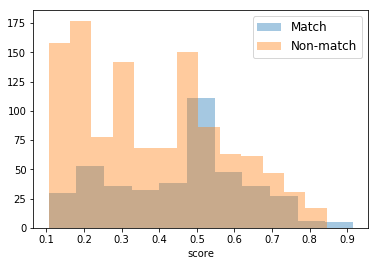

In [149]:
sns.distplot(merged[merged['exact_match'] == True]['score'], label='Match', kde=False)
sns.distplot(merged[merged['exact_match'] == False]['score'], label='Non-match', kde=False)
plt.legend(prop={'size': 12})

In [150]:
# exact_correct_df.to_csv(
#     '../results/{model}/predictions/{myclass}_correct.csv'.format(model = model_iter, myclass = predicted_class))
# exact_incorrect_df.to_csv(
#     '../results/{model}/predictions/{myclass}_incorrect.csv'.format(model = model_iter, myclass = predicted_class))

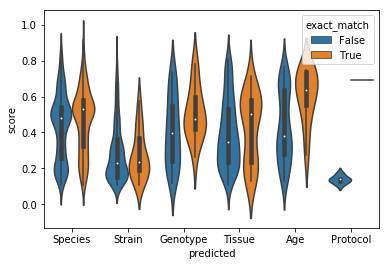

In [151]:
ax = sns.violinplot(x='predicted', y='score', data=merged, hue='exact_match')

### Contained within

In [158]:
def within(x):
    if (x["actual"] in x['token']) or (x['token'] in x["actual"]):
        return True
    else:
        return False

In [159]:
merged['within'] = merged.apply(within, axis=1)
count = merged['within'].sum()

In [160]:
print(('%d/%d (%.2f%%) of predicted contained in actual' % 
       (count, predicted_count, count/predicted_count*100)))

1187/1568 (75.70%) of predicted contained in actual


In [203]:
class_contain = merged.groupby(['predicted', 'within']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='within')
class_contain.columns = ["non-match", "match"]
class_contain["fraction_match"] = class_contain["match"]/class_contain.sum(axis=1)

In [204]:
class_contain

,non-match,match,fraction_match
predicted,,,
Age,60,34,0.361702
Genotype,33,23,0.410714
Protocol,3,3,0.500000
Species,77,751,0.907005
Strain,85,312,0.785894
Tissue,123,64,0.342246


### Cosine similarity

In [169]:
predicted_docs = nlp.pipe(merged['token'].tolist())
predicted_vectors = np.array([doc.vector for doc in predicted_docs])

actual_docs = nlp.pipe(merged['actual'].tolist())
actual_vectors = np.array([doc.vector for doc in actual_docs])

In [170]:
similarities = []
for i in range(len(predicted_vectors)):
    cosine_sim = cosine_similarity(predicted_vectors[i].reshape(1,200), actual_vectors[i].reshape(1,200))
    similarities.append(float(cosine_sim))

In [185]:
merged["cosine_similarity"] = similarities

(array([  4., 336.,  34.,  33.,  29.,  37.,  40.,  87., 158., 810.]),
 array([-0.13195045, -0.01875538,  0.09443969,  0.20763475,  0.32082982,
         0.43402489,  0.54721996,  0.66041503,  0.7736101 ,  0.88680517,
         1.00000024]),
 <a list of 10 Patch objects>)

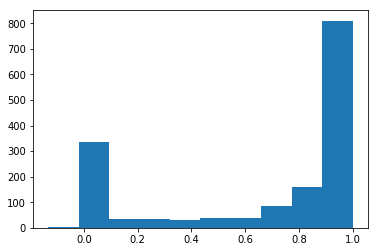

In [188]:
plt.hist(merged['cosine_similarity'])

In [191]:
sim_threshold = 0.8
merged["cosine_match"] = merged['cosine_similarity'].values > sim_threshold
num_sim = merged["cosine_match"].sum()

In [190]:
print(('%d/%d (%.2f%%) Predicted with cosine similarity greater than %.1f\n' 
                     % (num_sim, predicted_count, num_sim/predicted_count*100, sim_threshold)))

940/1568 (59.95%) Predicted with cosine similarity greater than 0.8



In [199]:
class_cosine = merged.groupby(['predicted', 'cosine_match']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='cosine_match')
class_cosine.columns = ["non-match", "match"]
class_cosine["fraction_match"] = class_cosine["match"]/class_cosine.sum(axis=1)

In [200]:
class_cosine

,non-match,match,fraction_match
predicted,,,
Age,58,36,0.382979
Genotype,35,21,0.375000
Protocol,4,2,0.333333
Species,64,764,0.922705
Strain,355,42,0.105793
Tissue,112,75,0.401070


In [229]:
title_counts = pd.DataFrame(pd.Series(validation_data_count), columns=['titles'])

In [236]:
class_contain

,non-match,match,fraction_match
predicted,,,
Age,60,34,0.361702
Genotype,33,23,0.410714
Protocol,3,3,0.500000
Species,77,751,0.907005
Strain,85,312,0.785894
Tissue,123,64,0.342246


In [264]:
table1 = class_cosine.merge(pd.DataFrame(merged["predicted"].value_counts()), left_index=True, right_index=True)
table1 = table1.merge(title_counts, left_index=True, right_index=True)
table1 = table1.merge(class_contain, left_index=True, right_index=True, suffixes=['_cosine', '_contain'])

In [265]:
table1["fraction_predicted"] = table1['predicted']/table1['titles']

In [266]:
table1

,non-match_cosine,match_cosine,fraction_match_cosine,predicted,titles,non-match_contain,match_contain,fraction_match_contain,fraction_predicted
Age,58,36,0.382979,94,541,60,34,0.361702,0.173752
Genotype,35,21,0.375000,56,340,33,23,0.410714,0.164706
Protocol,4,2,0.333333,6,15,3,3,0.500000,0.400000
Species,64,764,0.922705,828,1000,77,751,0.907005,0.828000
Strain,355,42,0.105793,397,1000,85,312,0.785894,0.397000
Tissue,112,75,0.401070,187,792,123,64,0.342246,0.236111


In [268]:
table1 = table1[['titles', 'predicted', 'fraction_predicted', 
        'match_cosine', 'fraction_match_cosine', 'match_contain', 'fraction_match_contain']]

In [269]:
table1['percent_correct'] = table1[["fraction_match_cosine", "fraction_match_contain"]].max(axis=1)

In [270]:
table1

,titles,predicted,fraction_predicted,match_cosine,fraction_match_cosine,match_contain,fraction_match_contain,percent_correct
Age,541,94,0.173752,36,0.382979,34,0.361702,0.382979
Genotype,340,56,0.164706,21,0.375000,23,0.410714,0.410714
Protocol,15,6,0.400000,2,0.333333,3,0.500000,0.500000
Species,1000,828,0.828000,764,0.922705,751,0.907005,0.922705
Strain,1000,397,0.397000,42,0.105793,312,0.785894,0.785894
Tissue,792,187,0.236111,75,0.401070,64,0.342246,0.401070


In [271]:
table1.to_csv('../doc/tables/Table1.csv', index=True)

#### BLEU scoring

In [66]:
def bleu1(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(1, 0, 0, 0), smoothing_function=smoother.method1)

def bleu4(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(0, 0, 0, 1), smoothing_function=smoother.method1)

In [67]:
smoother = SmoothingFunction()
similar_df["BLUE1"] = similar_df.apply(bleu1, axis=1)
similar_df["BLUE4"] = similar_df.apply(bleu4, axis=1)

#### Levenshtein distance

In [68]:
def levenshtein(x):
    return Levenshtein.distance(x["predicted"], x["actual"])

In [69]:
similar_df["levenshtein"] = similar_df.apply(levenshtein, axis=1)